In [50]:
import sys
sys.path.append('../../src')
import pandas
import random
import math
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process, ProcessMode, VaryingProcess
from energiapy.components.location import Location
from energiapy.components.transport import Transport
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
# from energiapy.model.constraints.demand import constraint_demand2
from energiapy.components.result import Result
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.plot import plot_results, plot_scenario, plot_location
from energiapy.model.solve import solve
from pyomo.environ import Param
from energiapy.utils.scale_utils import scale_pyomo_set

In [51]:
_time_intervals = 30  # Number of time intervals in a planning horizon
_coms = 1
_exec_scenarios = 12  # Number of execution scenarios
M = 1e3  # Big M

init = [1]

loc1_varying_factor = pandas.DataFrame(data={'com1_pur': [1, 0.58, 0.54, 0.07, 0.69, 0.17, 0.53, 0.35, 0.48, 0.39, 0.51, 0.38]})

loc6_varying_factor = pandas.DataFrame(data={'com1_pur': [1, 0.26, 0.66, 0.28, 0.65, 0.01, 0.49, 0.39, 0.61, 0.44, 0.3, 0.68]})

# loc1_varying_factor = pandas.DataFrame(data={'com1_pur': init+[round(random.uniform(0, 0.75), 2) for _ in range(_exec_scenarios-1)]})
# 
# loc6_varying_factor = pandas.DataFrame(data={'com1_pur': init+[round(random.uniform(0, 0.75), 2) for _ in range(_exec_scenarios-1)]})

# Define temporal scales
scales = TemporalScale(discretization_list=[_exec_scenarios, _time_intervals])

In [52]:
# ======================================================================================================================
# Declare resources/commodities
# ======================================================================================================================

com1_pur = Resource(name='com1_pur', cons_max=125, block={'imp': 1, 'urg': 1}, price=0.00, label='Commodity 1 consumed from outside the system', varying=[VaryingResource.DETERMINISTIC_AVAILABILITY])

com1_in = Resource(name='com1_in', label='Commodity 1 received')
com1_out = Resource(name='com1_out', label='Commodity 1 to be sent out')

com1_loc1_out = Resource(name='com1_loc1_out', label='Commodity 1 sent out from location 1')
com1_loc2_out = Resource(name='com1_loc2_out', label='Commodity 1 sent out from location 2')
com1_loc3_out = Resource(name='com1_loc3_out', label='Commodity 1 sent out from location 3')
com1_loc4_out = Resource(name='com1_loc4_out', label='Commodity 1 sent out from location 4')
com1_loc5_out = Resource(name='com1_loc5_out', label='Commodity 1 sent out from location 5')
com1_loc6_out = Resource(name='com1_loc6_out', label='Commodity 1 sent out from location 6')
com1_loc7_out = Resource(name='com1_loc7_out', label='Commodity 1 sent out from location 7')

com1_sold = Resource(name='com1_sold', revenue=0.00, demand=True, sell=True, label='Commodity 1 sold to outside the system')

In [53]:
# ======================================================================================================================
# Declare processes/storage capacities
# ======================================================================================================================
com1_procure = Process(name='procure com1', prod_max=125, conversion={com1_pur: -1, com1_in: 1}, capex=0.1, vopex=0.1, prod_min=125,
                  label='Procure com1')
com1_sell = Process(name='sell com1', prod_max=M, conversion={com1_out: -1, com1_sold: 1}, capex=0.1, vopex=0.1, prod_min=M,
                  label='Sell com1')

com1_receive_loc1 = Process(name='com1_receive_loc1', prod_max=100, conversion={com1_loc1_out:-1, com1_in:1}, capex=0.1, vopex=0.1, prod_min=100,
                            label='Commodity 1 received from location 1')
com1_receive_loc2 = Process(name='com1_receive_loc2', prod_max=100, conversion={com1_loc2_out:-1, com1_in:1}, capex=0.1, vopex=0.1, prod_min=100,
                            label='Commodity 1 received from location 2')
com1_receive_loc3 = Process(name='com1_receive_loc3', prod_max=100, conversion={com1_loc3_out:-1, com1_in:1}, capex=0.1, vopex=0.1, prod_min=100,
                            label='Commodity 1 received from location 3')
com1_receive_loc4 = Process(name='com1_receive_loc4', prod_max=100, conversion={com1_loc4_out:-1, com1_in:1}, capex=0.1, vopex=0.1, prod_min=100,
                            label='Commodity 1 received from location 4')
com1_receive_loc5 = Process(name='com1_receive_loc5', prod_max=100, conversion={com1_loc5_out:-1, com1_in:1}, capex=0.1, vopex=0.1, prod_min=100,
                            label='Commodity 1 received from location 5')
com1_receive_loc6 = Process(name='com1_receive_loc6', prod_max=100, conversion={com1_loc6_out:-1, com1_in:1}, capex=0.1, vopex=0.1, prod_min=100,
                            label='Commodity 1 received from location 6')
com1_receive_loc7 = Process(name='com1_receive_loc7', prod_max=100, conversion={com1_loc7_out:-1, com1_in:1}, capex=0.1, vopex=0.1, prod_min=100,
                            label='Commodity 1 received from location 7')

com1_process = Process(name='com1_process', prod_max=100, conversion={com1_in:-1, com1_out:1}, capex=0.1, vopex=0.1, prod_min=100,
                            label='Process the commodity through the location')

com1_store10 = Process(name='com1_store10', prod_max=100, capex=100, vopex=1, store_min=0.01, store_max= 10, prod_min=100,
                  label="Storage capacity of 10 units", storage=com1_in, storage_cost=0.02)

com1_store20 = Process(name='com1_store20', prod_max=100, capex=200, vopex=2, store_min=0.01,store_max= 20, prod_min=100,
                  label="Storage capacity of 20 units", storage=com1_in, storage_cost=0.02)

com1_store50 = Process(name='com1_store50', prod_max=100, capex=500, vopex=5, store_min=0.01, store_max= 50, prod_min=100,
                  label="Storage capacity of 50 units", storage=com1_in, storage_cost=0.02)

com1_loc1_send = Process(name='com1_loc1_send', prod_max=100, conversion={com1_out:-1, com1_loc1_out:1}, capex=0.1, vopex=0.1, prod_min=100,
                            label='Send commodity one from location 1')
com1_loc2_send = Process(name='com1_loc2_send', prod_max=100, conversion={com1_out:-1, com1_loc2_out:1}, capex=0.1, vopex=0.1, prod_min=100,
                            label='Send commodity one from location 2')
com1_loc3_send = Process(name='com1_loc3_send', prod_max=100, conversion={com1_out:-1, com1_loc3_out:1}, capex=0.1, vopex=0.1, prod_min=100,
                            label='Send commodity one from location 3')
com1_loc4_send = Process(name='com1_loc4_send', prod_max=100, conversion={com1_out:-1, com1_loc4_out:1}, capex=0.1, vopex=0.1, prod_min=100,
                            label='Send commodity one from location 4')
com1_loc5_send = Process(name='com1_loc5_send', prod_max=100, conversion={com1_out:-1, com1_loc5_out:1}, capex=0.1, vopex=0.1, prod_min=100,
                            label='Send commodity one from location 5')
com1_loc6_send = Process(name='com1_loc6_send', prod_max=100, conversion={com1_out:-1, com1_loc6_out:1}, capex=0.1, vopex=0.1, prod_min=100,
                            label='Send commodity one from location 6')
com1_loc7_send = Process(name='com1_loc7_send', prod_max=100, conversion={com1_out:-1, com1_loc7_out:1}, capex=0.1, vopex=0.1, prod_min=100,
                            label='Send commodity one from location 7')

In [54]:
# ======================================================================================================================
# Declare locations/warehouses
# ======================================================================================================================
loc1 = Location(name='loc1', processes={com1_procure, com1_receive_loc2, com1_receive_loc3, com1_process, com1_store20, com1_loc1_send}, label="Location 1", scales=scales, demand_scale_level=1,
                capacity_scale_level=0, availability_scale_level=0, availability_factor={com1_pur: loc1_varying_factor[['com1_pur']]})

loc2 = Location(name='loc2', processes={com1_receive_loc1, com1_receive_loc4, com1_receive_loc5, com1_process, com1_store20, com1_loc2_send}, label="Location 2", scales=scales, demand_scale_level=1,
                capacity_scale_level=0, availability_scale_level=0)

loc3 = Location(name='loc3', processes={com1_receive_loc1, com1_receive_loc4, com1_process, com1_store20, com1_loc3_send}, label="Location 3", scales=scales, demand_scale_level=1,
                capacity_scale_level=0, availability_scale_level=0)

loc4 = Location(name='loc4', processes={com1_receive_loc2, com1_receive_loc3, com1_receive_loc6, com1_receive_loc5, com1_receive_loc7, com1_process, com1_store50, com1_loc4_send}, label="Location 4", scales=scales, demand_scale_level=1,
                capacity_scale_level=0, availability_scale_level=0)

loc5 = Location(name='loc5', processes={com1_receive_loc2, com1_receive_loc4, com1_receive_loc7, com1_process, com1_store50, com1_loc5_send, com1_sell}, label="Location 5", scales=scales, demand_scale_level=1,
                capacity_scale_level=0, availability_scale_level=0)

loc6 = Location(name='loc6', processes={com1_procure, com1_receive_loc4, com1_process, com1_store10, com1_loc6_send}, label="Location 6", scales=scales, demand_scale_level=1,
                capacity_scale_level=0, availability_scale_level=0, availability_factor={com1_pur: loc6_varying_factor[['com1_pur']]})

loc7 = Location(name='loc7', processes={com1_receive_loc4, com1_receive_loc5, com1_process, com1_store20, com1_loc7_send}, label="Location 7", scales=scales, demand_scale_level=1,
                capacity_scale_level=0, availability_scale_level=0)

In [55]:
# ======================================================================================================================
# Declare transport/trucks
# ======================================================================================================================

truck50_12 = Transport(name='truck50_12', resources={com1_loc1_out}, trans_max=50, label='Truck capacity of 50 units from location 1 to 2', capex=0.5, vopex=0.05, trans_min=50)
truck50_21 = Transport(name='truck50_21', resources={com1_loc2_out}, trans_max=50, label='Truck capacity of 50 units from location 2 to 1', capex=0.0001, vopex=0.05, trans_min=50)

truck30_13 = Transport(name='truck30_13', resources={com1_loc1_out}, trans_max=30, label='Truck capacity of 30 units from location 1 to 3', capex=0.3, vopex=0.03, trans_min=30)
truck30_31 = Transport(name='truck30_31', resources={com1_loc3_out}, trans_max=30, label='Truck capacity of 30 units from location 3 to 1', capex=0.0001, vopex=0.03, trans_min=30)

truck50_24 = Transport(name='truck50_24', resources={com1_loc2_out}, trans_max=50, label='Truck capacity of 50 units from location 2 to 4', capex=0.5, vopex=0.05, trans_min=50)
truck50_42 = Transport(name='truck50_42', resources={com1_loc4_out}, trans_max=50, label='Truck capacity of 50 units from location 4 to 2', capex=0.0001, vopex=0.05, trans_min=50)

truck30_25 = Transport(name='truck30_25', resources={com1_loc2_out}, trans_max=30, label='Truck capacity of 30 units from location 2 to 5', capex=0.3, vopex=0.03, trans_min=30)
truck30_52 = Transport(name='truck30_52', resources={com1_loc5_out}, trans_max=30, label='Truck capacity of 30 units from location 5 to 2', capex=0.0001, vopex=0.03, trans_min=30)

truck20_34 = Transport(name='truck20_34', resources={com1_loc3_out}, trans_max=20, label='Truck capacity of 20 units from location 3 to 4', capex=0.2, vopex=0.02, trans_min=20)
truck20_43 = Transport(name='truck20_43', resources={com1_loc4_out}, trans_max=20, label='Truck capacity of 20 units from location 4 to 3', capex=0.0001, vopex=0.02, trans_min=20)

truck100_45 = Transport(name='truck100_45', resources={com1_loc4_out}, trans_max=100, label='Truck capacity of 100 units from location 4 to 5', capex=1, vopex=0.1, trans_min=100)
truck100_54 = Transport(name='truck100_54', resources={com1_loc5_out}, trans_max=100, label='Truck capacity of 100 units from location 5 to 4', capex=0.0001, vopex=0.1, trans_min=100)

truck40_47 = Transport(name='truck40_47', resources={com1_loc4_out}, trans_max=40, label='Truck capacity of 40 units from location 4 to 7', capex=0.4, vopex=0.04, trans_min=40)
truck40_74 = Transport(name='truck40_74', resources={com1_loc7_out}, trans_max=40, label='Truck capacity of 40 units from location 7 to 4', capex=0.0001, vopex=0.04, trans_min=40)

truck50_64 = Transport(name='truck50_64', resources={com1_loc6_out}, trans_max=50, label='Truck capacity of 50 units from location 6 to 4', capex=0.5, vopex=0.05, trans_min=50)
truck50_46 = Transport(name='truck50_46', resources={com1_loc4_out}, trans_max=50, label='Truck capacity of 50 units from location 4 to 6', capex=0.0001, vopex=0.05, trans_min=50)

truck40_75 = Transport(name='truck40_75', resources={com1_loc7_out}, trans_max=40, label='Truck capacity of 40 units from location 7 to 5', capex=0.4, vopex=0.04, trans_min=40)
truck40_57 = Transport(name='truck40_57', resources={com1_loc5_out}, trans_max=40, label='Truck capacity of 40 units from location 5 to 7', capex=0.0001, vopex=0.04, trans_min=40)

In [56]:
# ======================================================================================================================
# Declare network
# ======================================================================================================================
transport_matrix = [
    [[], [truck50_12], [truck30_13], [], [], [], []],  # source: location 1
    [[truck50_21], [], [], [truck50_24], [truck30_25], [], []],  # source: location 2
    [[truck30_31], [], [], [truck20_34], [], [], []],  # source: location 3
    [[], [truck50_42], [truck20_43], [], [truck100_45], [truck50_46], [truck40_47]],  # source: location 4
    [[], [truck30_52], [], [truck100_54], [], [], [truck40_57]],  # source: location 5
    [[], [], [], [truck50_64], [], [], []],  # source: location 6
    [[], [], [], [truck40_74], [truck40_75], [], []]  # source: location 7
]

distance_matrix = [
    [0, 55, 196, M, M, M, M],
    [55, 0, M, 163, 112, M, 134],
    [196, M, 0, 63, M, M, M],
    [M, 163, 63, 0, 95, 117, 88],
    [M, 112, M, 95, 0, M, 134],
    [M, M, M, 117, M, 0, M],
    [M, 134, M, 88, 134, M, 0]
]

locset = [loc1, loc2, loc3, loc4, loc5, loc6, loc7]

sources = locset
sinks = locset

network = Network(name='Network', scales= scales, source_locations=sources, sink_locations=sinks, transport_matrix=transport_matrix, distance_matrix=distance_matrix)

In [57]:
demand_dict = {i: {com1_sold: 100} if i == loc5 else {com1_sold: 0} for i in locset}
demand_penalty_dict = {i: {com1_sold: 1000} if i == loc5 else {com1_sold: 0} for i in locset}

scenario_res_baseline = Scenario(name='scenario_res_baseline', scales=scales, scheduling_scale_level=1, network_scale_level=0, purchase_scale_level=1, availability_scale_level=0, demand_scale_level=1, capacity_scale_level=0,
                    network=network, demand=demand_dict, demand_penalty=demand_penalty_dict, label='Baseline scenario for information sharing with resource variability', annualization_factor=1/12)

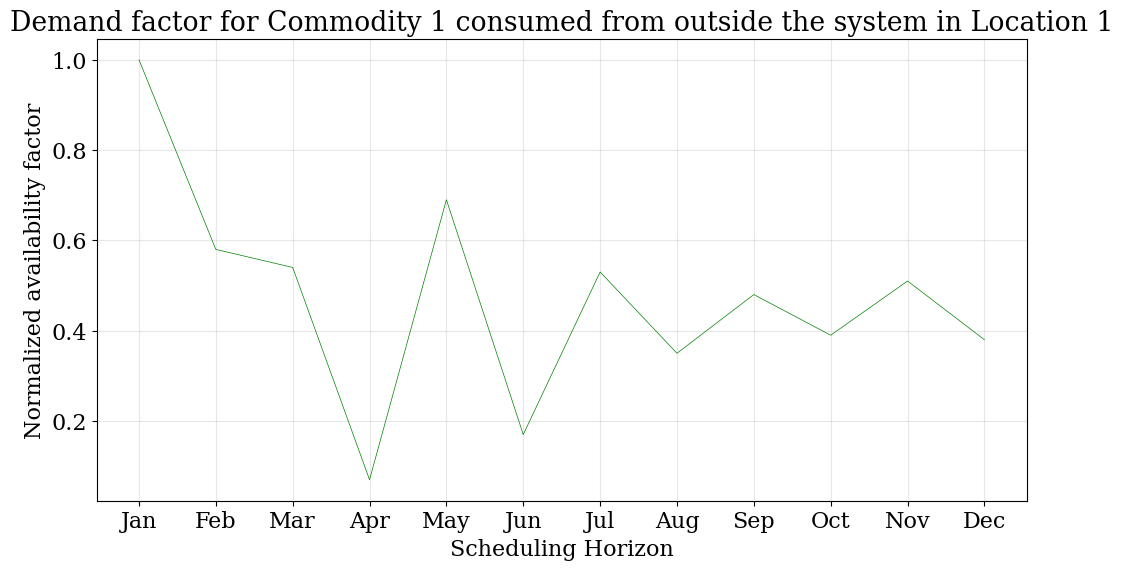

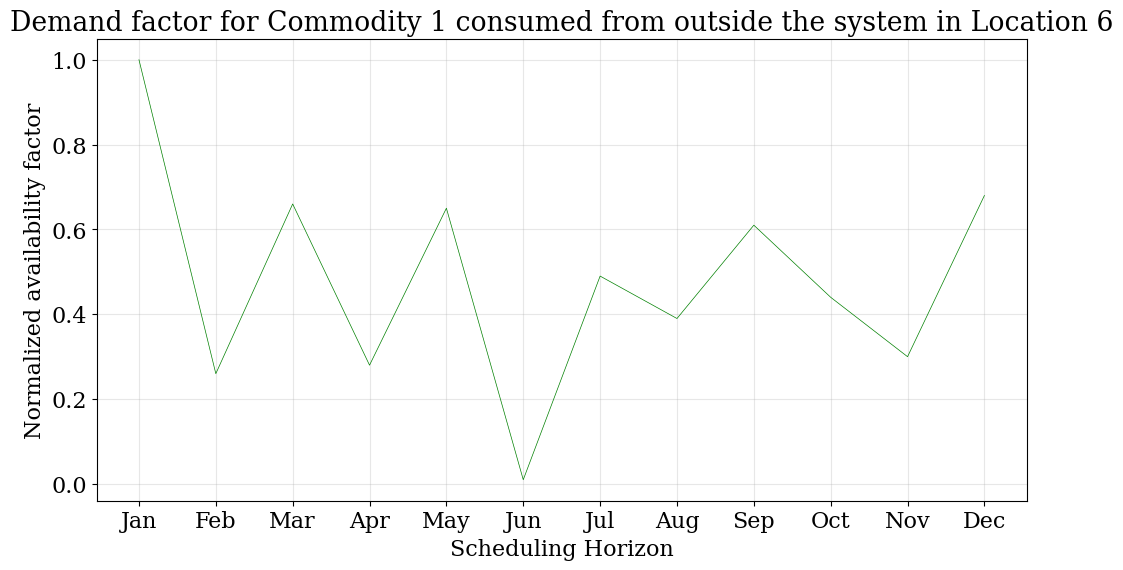

In [58]:
plot_scenario.availability_factor(scenario=scenario_res_baseline, resource=com1_pur, location=loc1, color='green')
plot_scenario.availability_factor(scenario=scenario_res_baseline, resource=com1_pur, location=loc6, color='green')

In [59]:
problem_mincost = formulate(scenario=scenario_res_baseline,
                            constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE,
                                         Constraints.INVENTORY, Constraints.PRODUCTION,  Constraints.DEMAND},
                            demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint production mode
constraint inventory balance
constraint inventory network
constraint resource export
constraint transport export
constraint export
constraint transport capex
constraint transport network capex
constraint transport export network
constraint transport vopex
constraint transport network vopex
constraint transport fopex
constraint transport network fopex
constraint transport capacity UB no bin
constraint transport capacity LB no bin
constraint demand penalty
objective cost w demand penalty


In [60]:
results_mincost = solve(scenario=scenario_res_baseline, instance=problem_mincost, solver='gurobi', name='MILP')

Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1001436 rows, 2876965 columns and 1390203 nonzeros
Model fingerprint: 0xe0f26697
Variable types: 2866381 continuous, 10584 integer (10584 binary)
Coefficient statistics:
  Matrix range     [5e-04, 1e+02]
  Objective range  [1e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 1e+03]
Found heuristic solution: objective 3.621490e+07
Presolve removed 995323 rows and 2861141 columns
Presolve time: 0.80s
Presolved: 6113 rows, 15824 columns, 30923 nonzeros
Variable types: 15824 continuous, 0 integer (0 binary)

Root relaxation: objective 4.329707e+06, 5458 iterations, 0.11 seconds (0.12 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0 

In [61]:
sum(value for key, value in results_mincost.output['S'].items() if key[0] == 'loc5' and key[1] == 'com1_sold') / (100*_exec_scenarios*_time_intervals)

0.898125

In [62]:
min(value for key, value in results_mincost.output['S'].items() if key[0] == 'loc5' and key[1] == 'com1_sold')

22.5

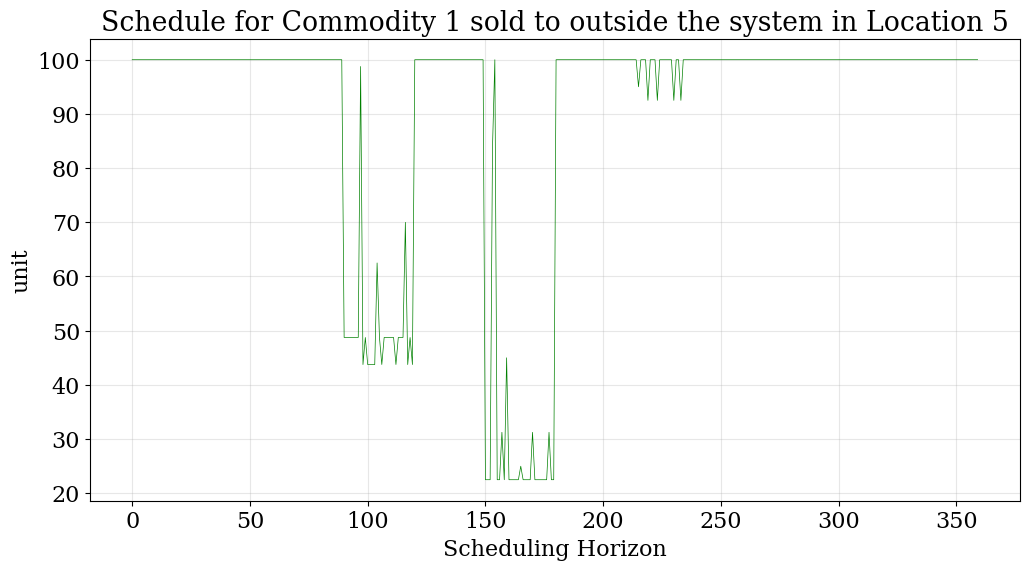

In [63]:
plot_results.schedule(results=results_mincost, y_axis='S', component='com1_sold', location='loc5', color='green')

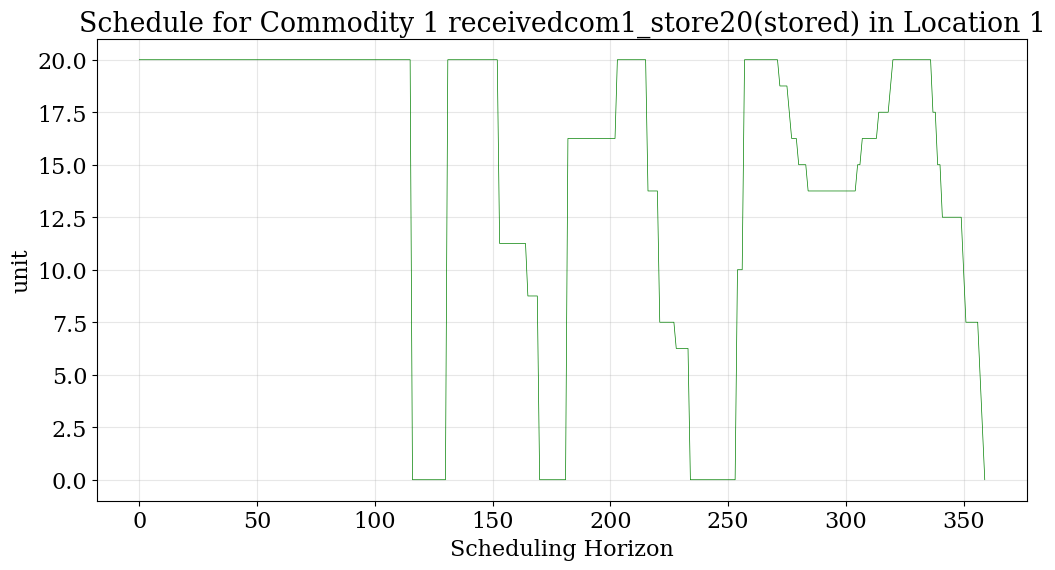

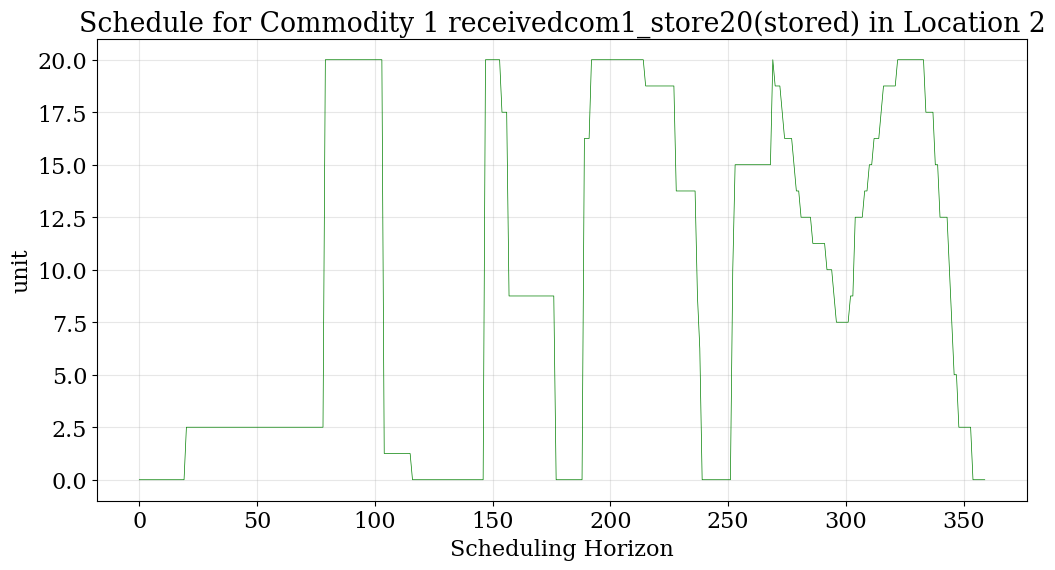

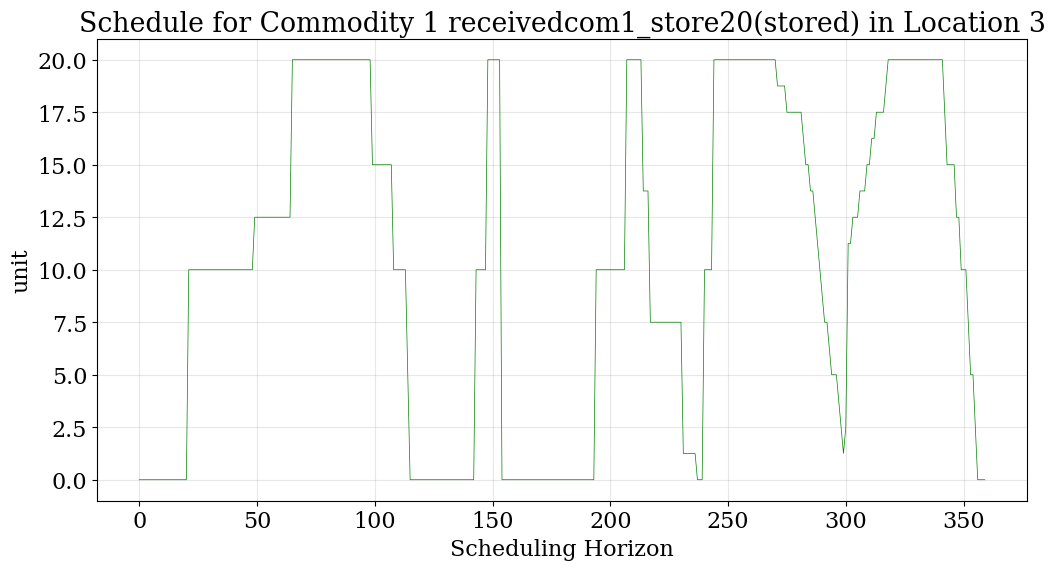

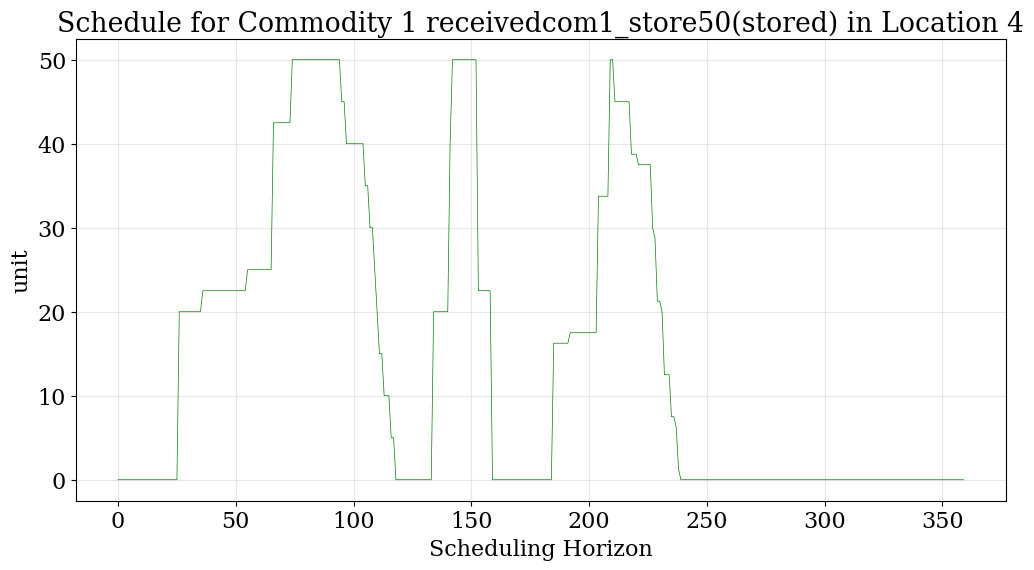

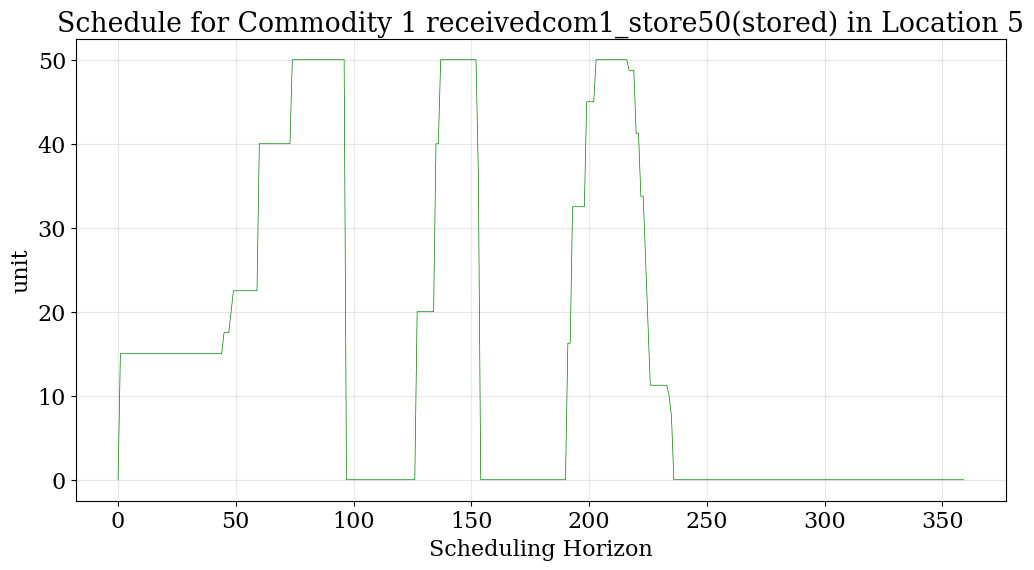

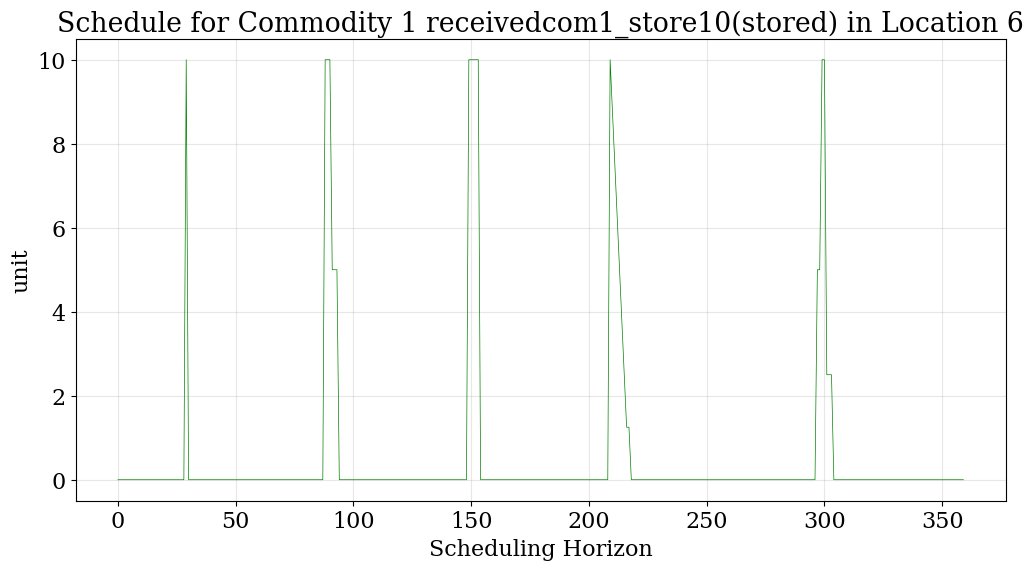

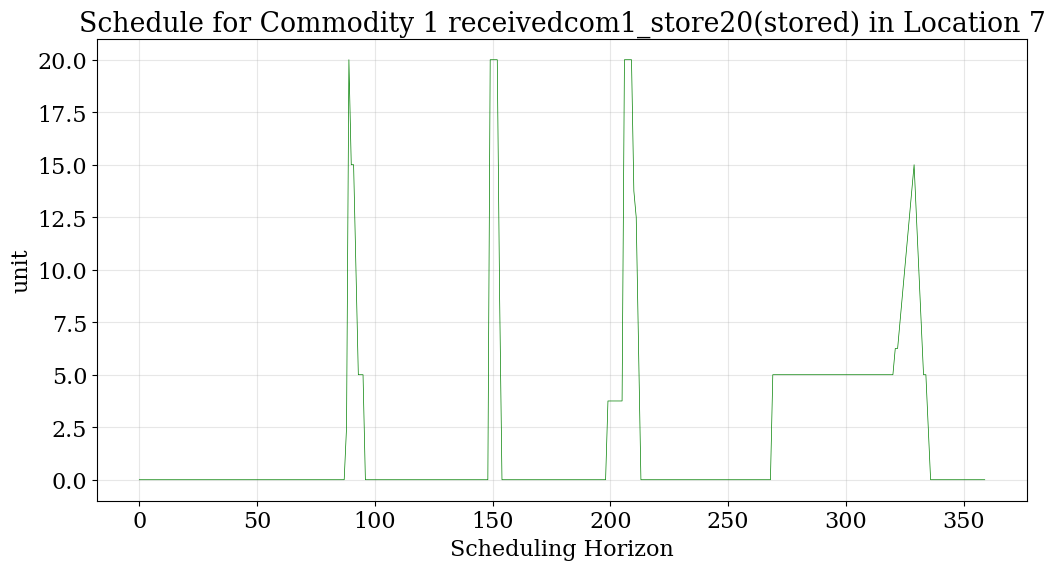

In [64]:
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store20_com1_in_stored', location='loc1', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store20_com1_in_stored', location='loc2', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store20_com1_in_stored', location='loc3', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store50_com1_in_stored', location='loc4', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store50_com1_in_stored', location='loc5', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store10_com1_in_stored', location='loc6', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store20_com1_in_stored', location='loc7', color='green')

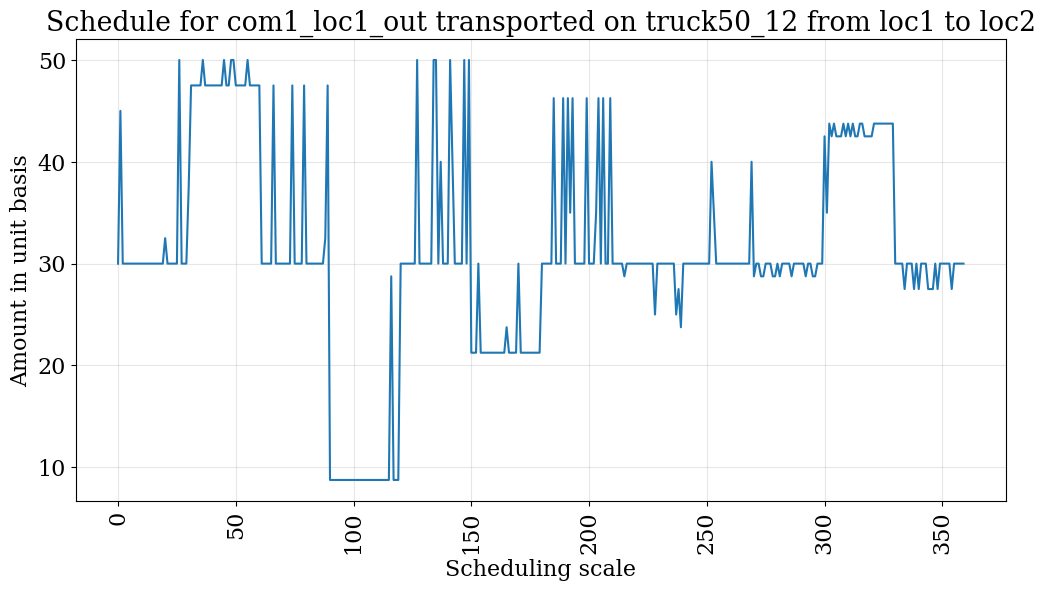

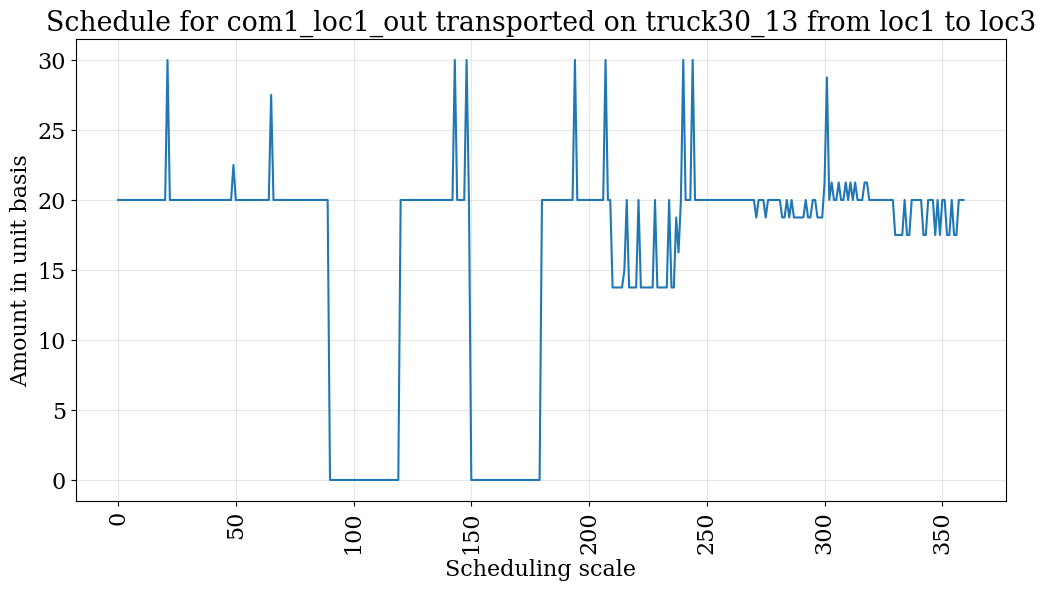

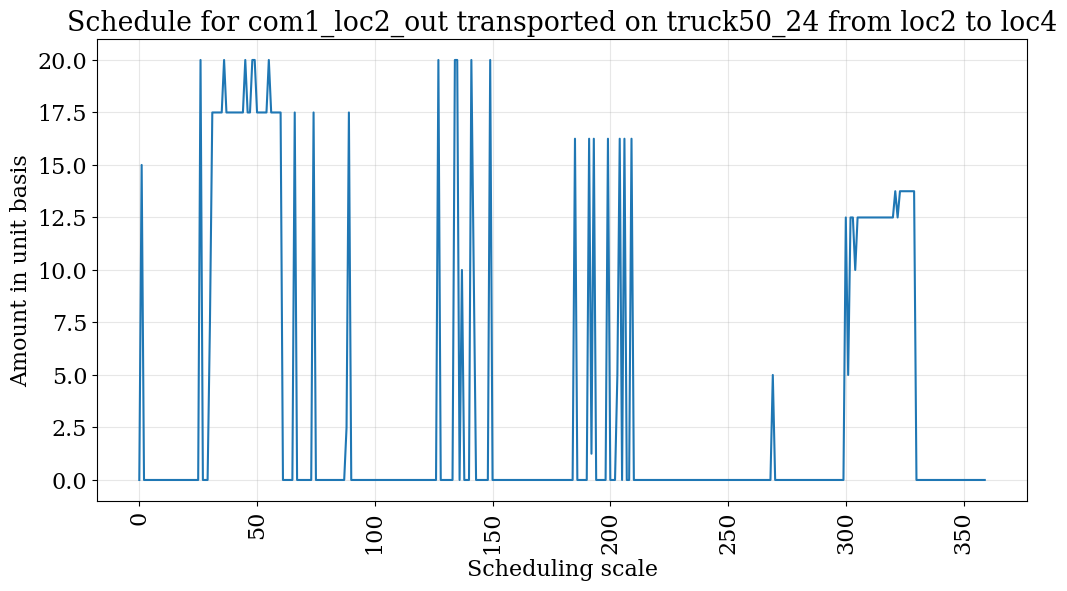

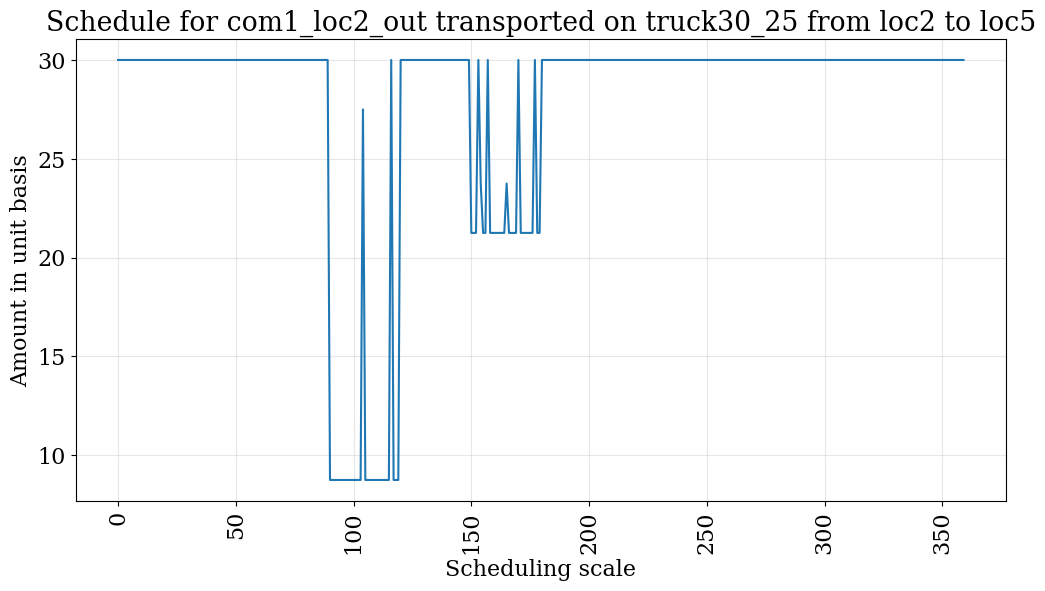

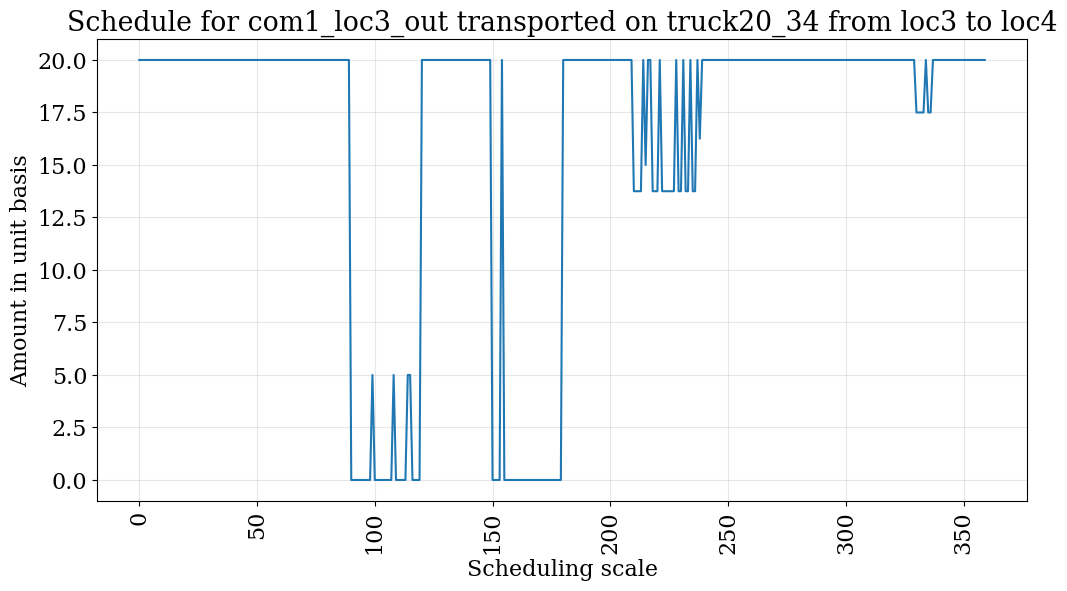

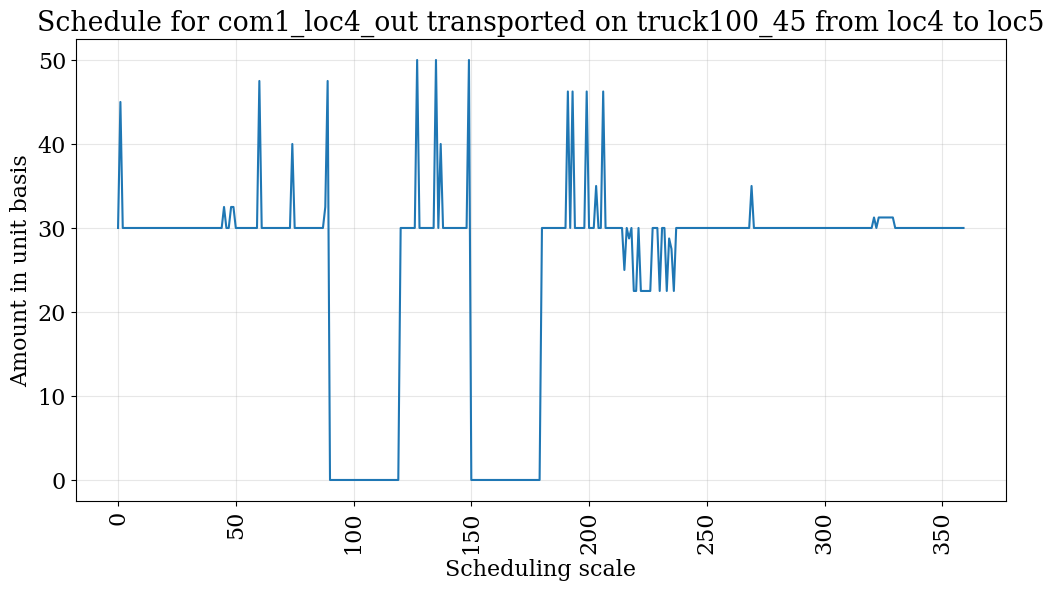

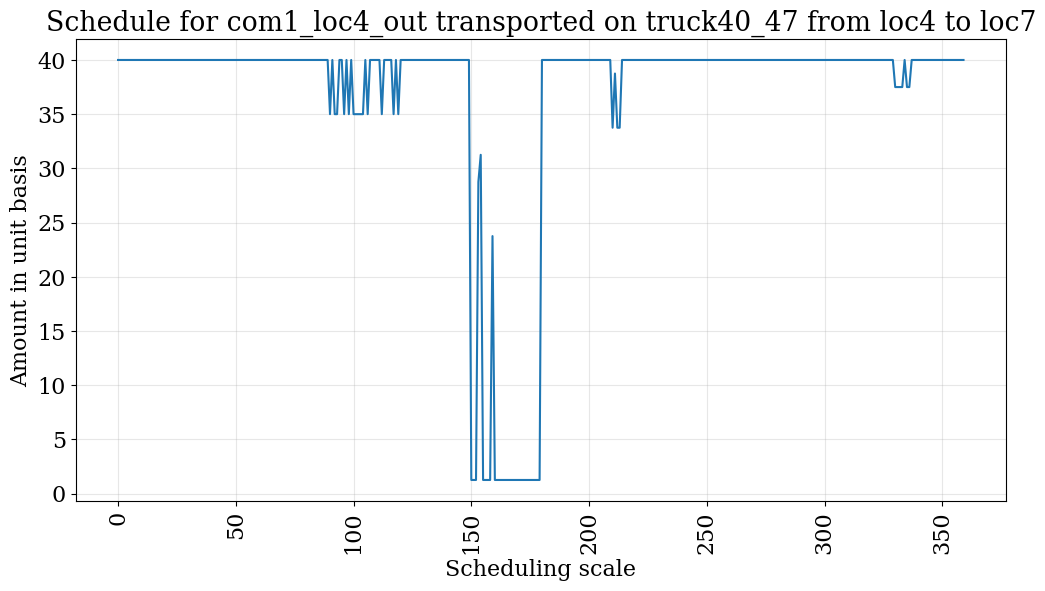

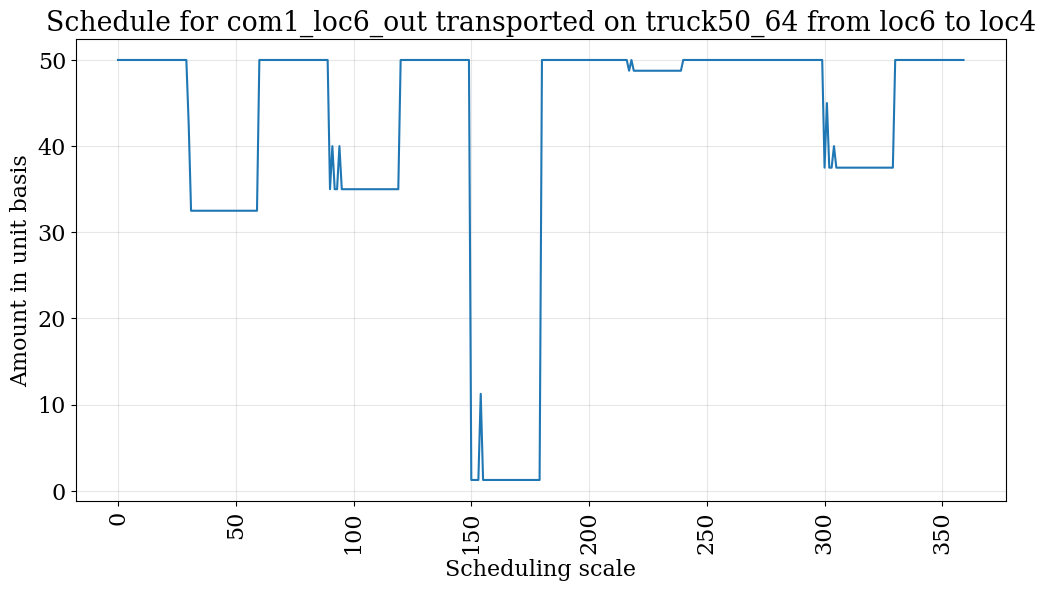

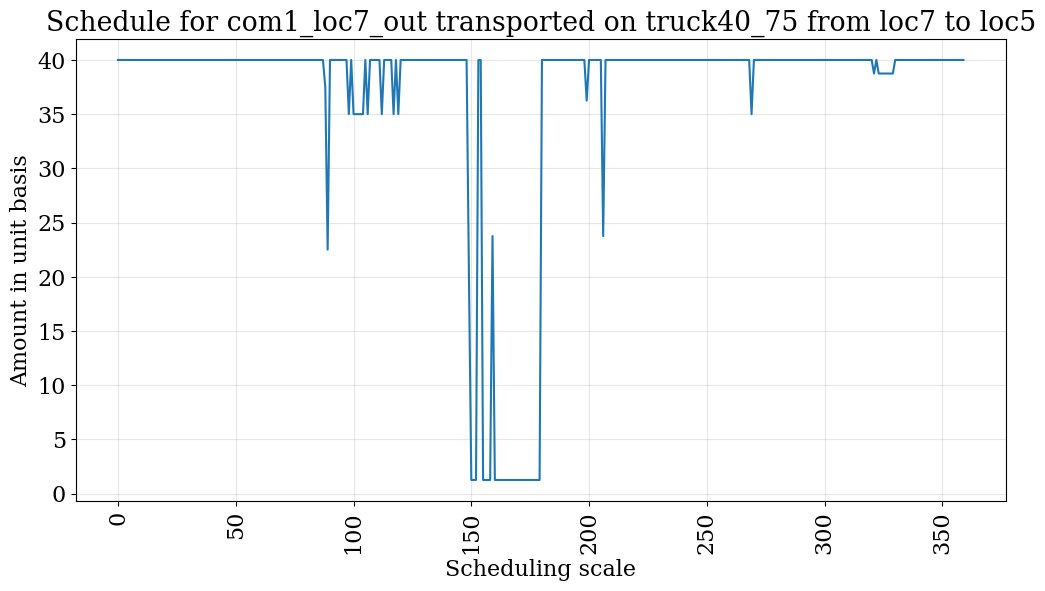

In [65]:
plot_results.transport(results=results_mincost, source='loc1', sink='loc2', transport='truck50_12',
                       resource='com1_loc1_out')
plot_results.transport(results=results_mincost, source='loc1', sink='loc3', transport='truck30_13',
                       resource='com1_loc1_out')
plot_results.transport(results=results_mincost, source='loc2', sink='loc4', transport='truck50_24',
                       resource='com1_loc2_out')
plot_results.transport(results=results_mincost, source='loc2', sink='loc5', transport='truck30_25',
                       resource='com1_loc2_out')
plot_results.transport(results=results_mincost, source='loc3', sink='loc4', transport='truck20_34',
                       resource='com1_loc3_out')
plot_results.transport(results=results_mincost, source='loc4', sink='loc5', transport='truck100_45',
                       resource='com1_loc4_out')
plot_results.transport(results=results_mincost, source='loc4', sink='loc7', transport='truck40_47',
                       resource='com1_loc4_out')
plot_results.transport(results=results_mincost, source='loc6', sink='loc4', transport='truck50_64',
                       resource='com1_loc6_out')
plot_results.transport(results=results_mincost, source='loc7', sink='loc5', transport='truck40_75',
                       resource='com1_loc7_out')

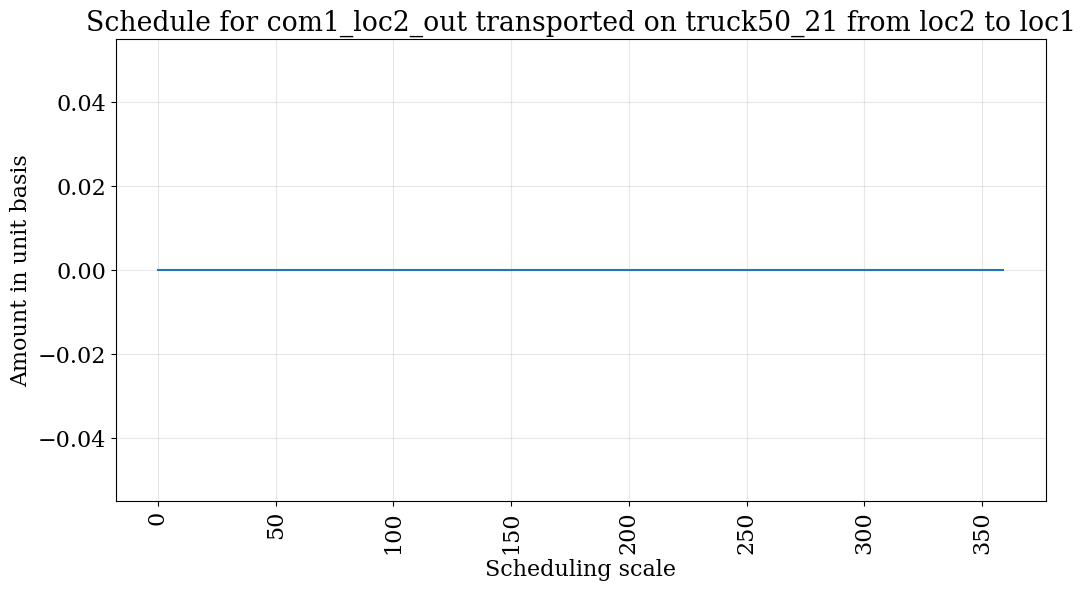

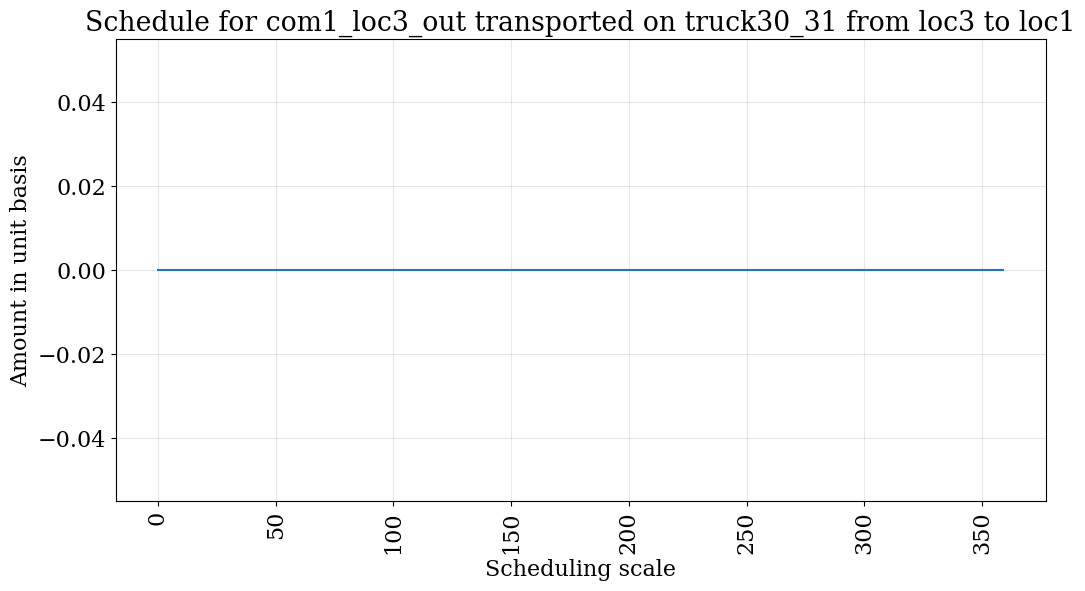

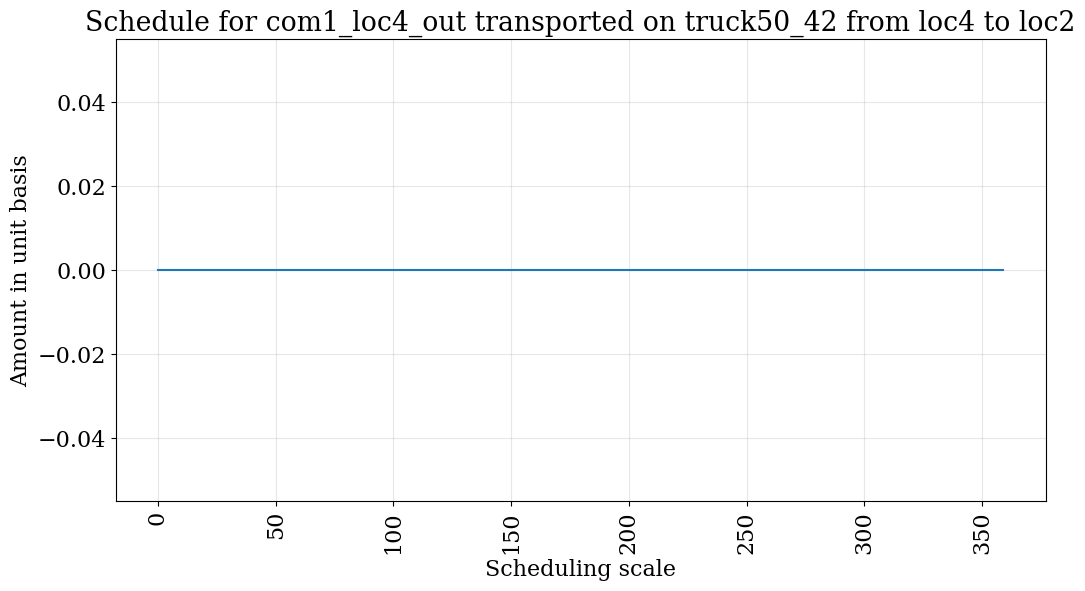

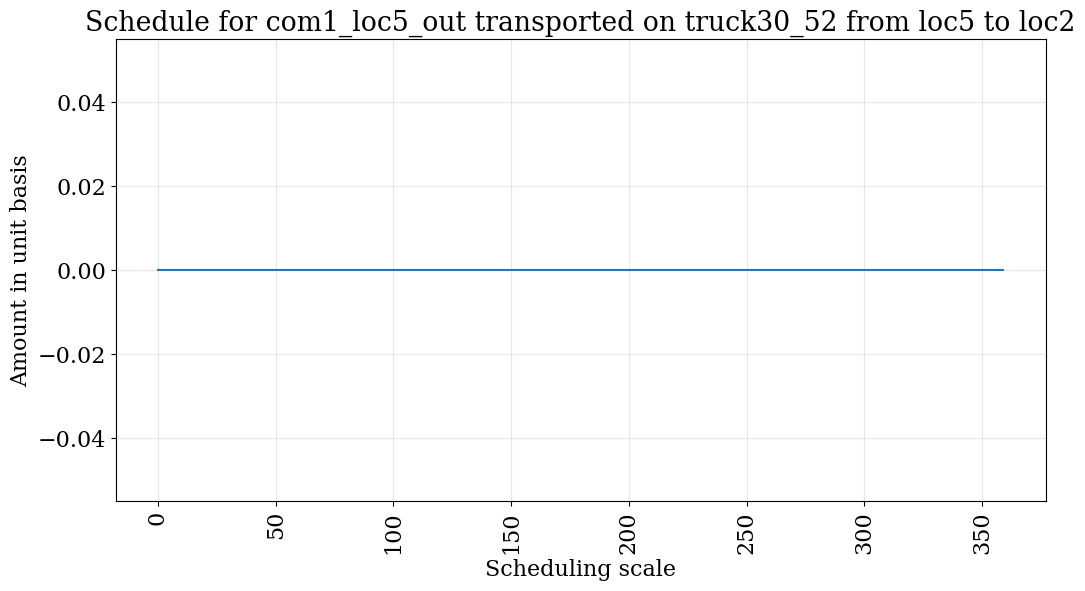

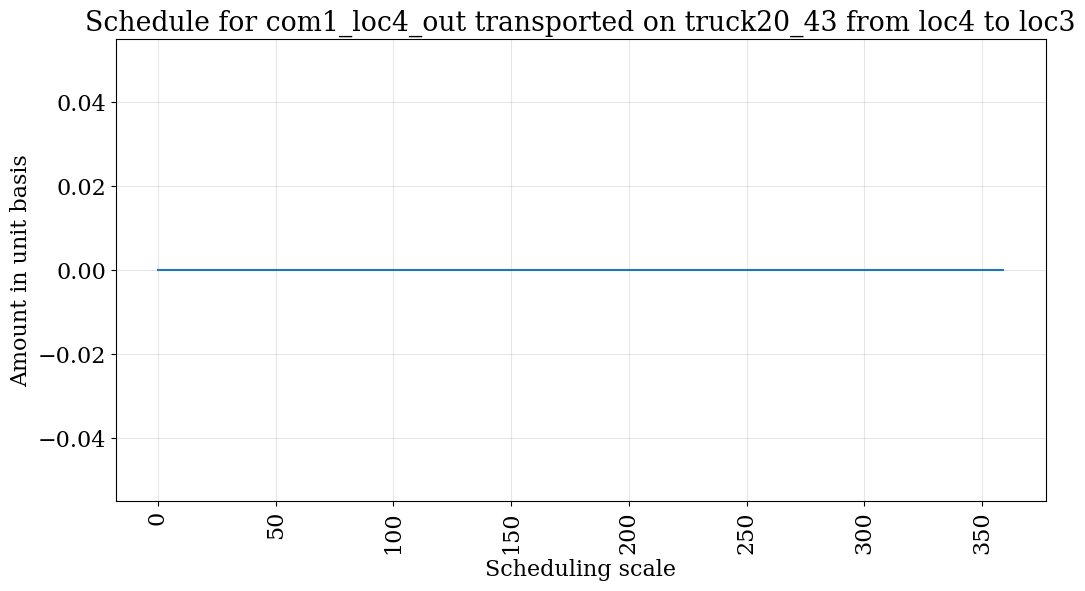

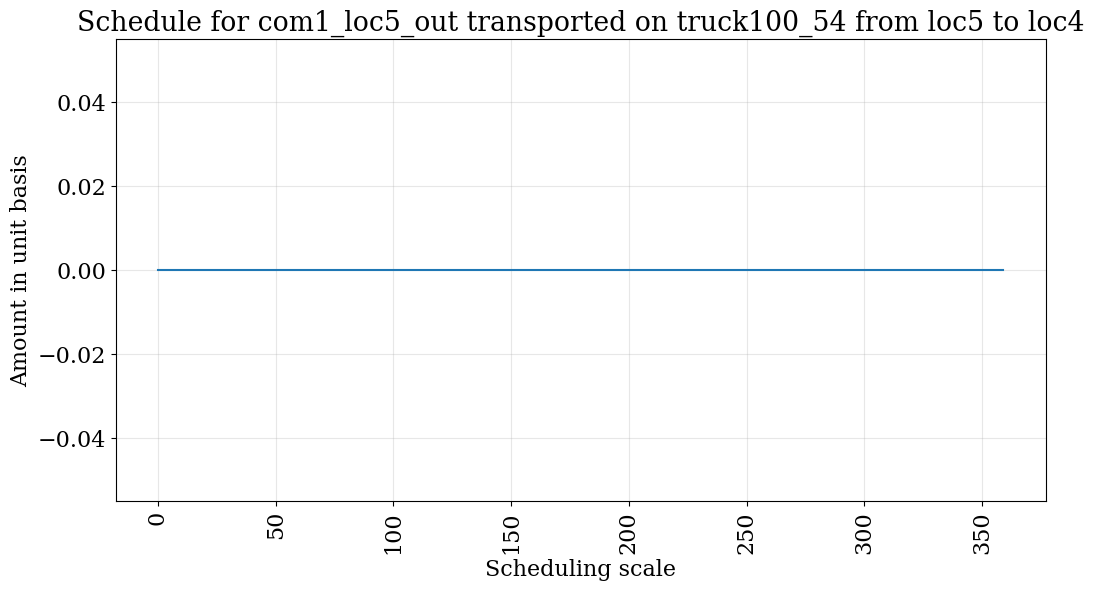

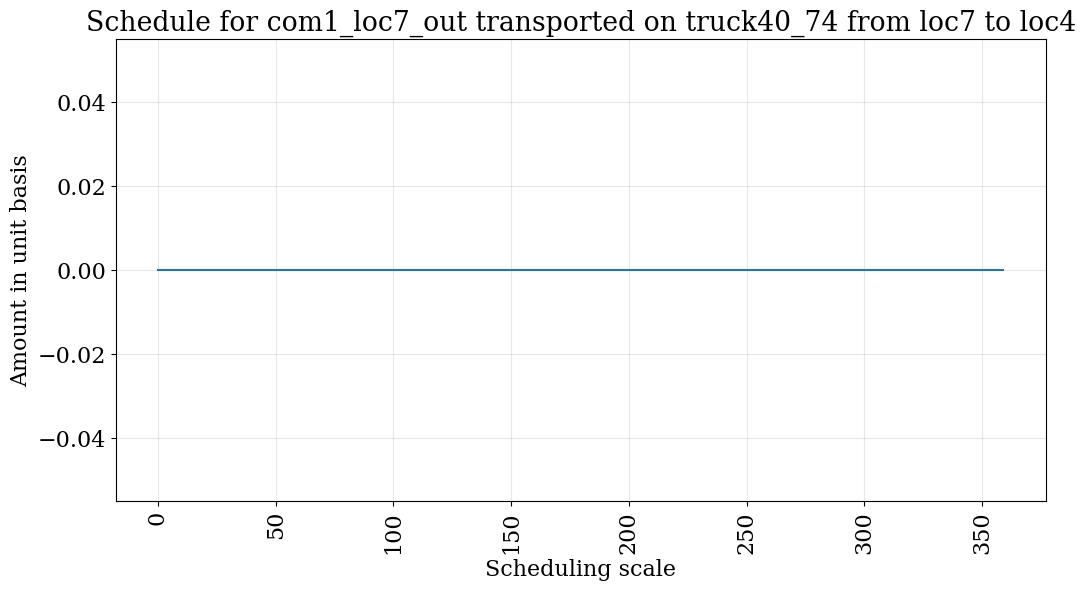

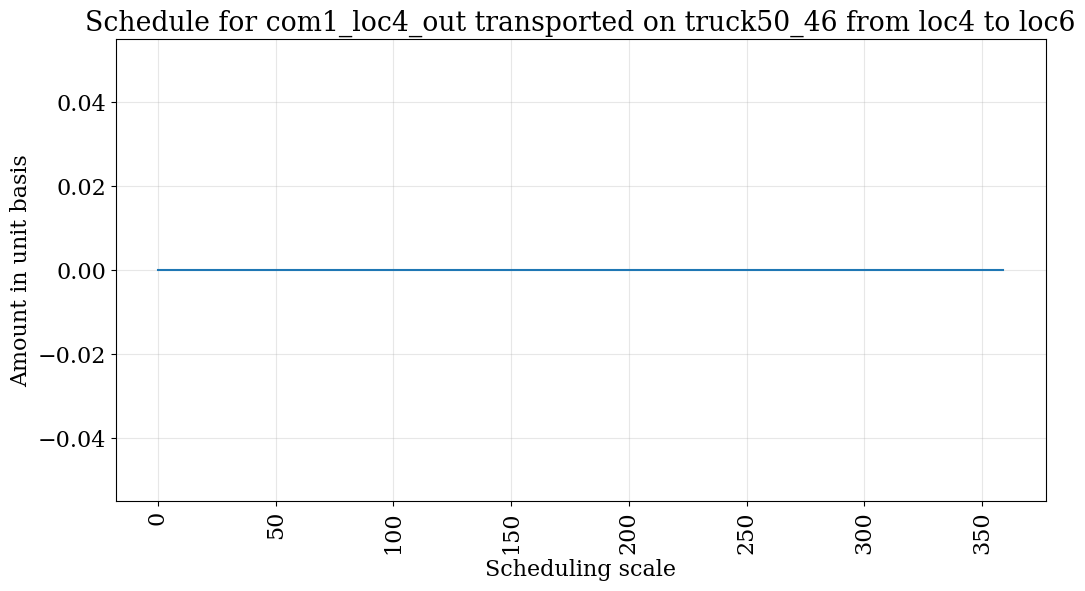

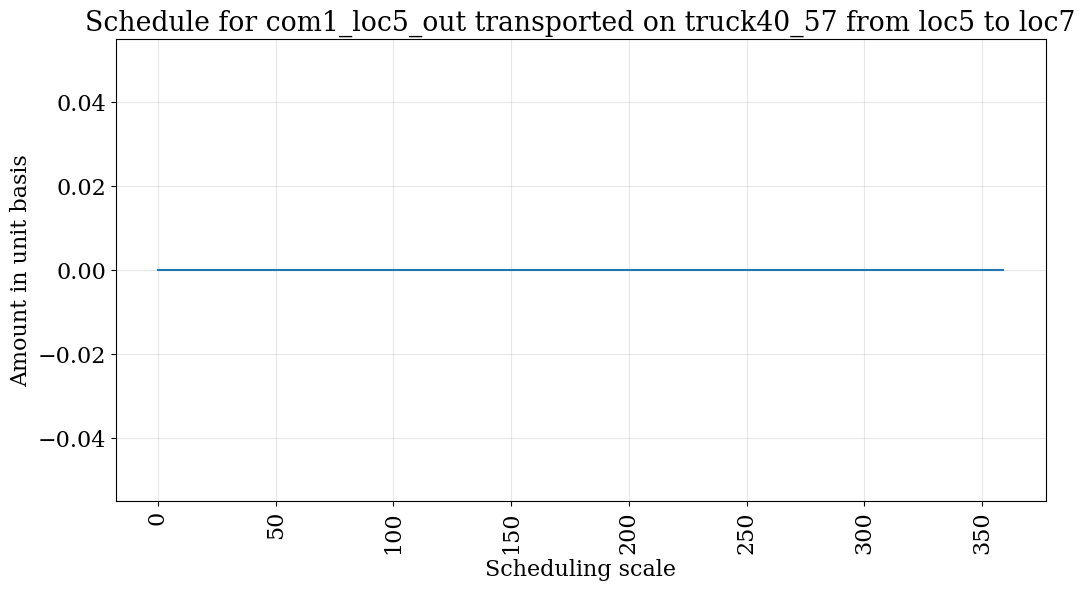

In [66]:
plot_results.transport(results=results_mincost, source='loc2', sink='loc1', transport='truck50_21',
                       resource='com1_loc2_out')
plot_results.transport(results=results_mincost, source='loc3', sink='loc1', transport='truck30_31',
                       resource='com1_loc3_out')
plot_results.transport(results=results_mincost, source='loc4', sink='loc2', transport='truck50_42',
                       resource='com1_loc4_out')
plot_results.transport(results=results_mincost, source='loc5', sink='loc2', transport='truck30_52',
                       resource='com1_loc5_out')
plot_results.transport(results=results_mincost, source='loc4', sink='loc3', transport='truck20_43',
                       resource='com1_loc4_out')
plot_results.transport(results=results_mincost, source='loc5', sink='loc4', transport='truck100_54',
                       resource='com1_loc5_out')
plot_results.transport(results=results_mincost, source='loc7', sink='loc4', transport='truck40_74',
                       resource='com1_loc7_out')
plot_results.transport(results=results_mincost, source='loc4', sink='loc6', transport='truck50_46',
                       resource='com1_loc4_out')
plot_results.transport(results=results_mincost, source='loc5', sink='loc7', transport='truck40_57',
                       resource='com1_loc5_out')

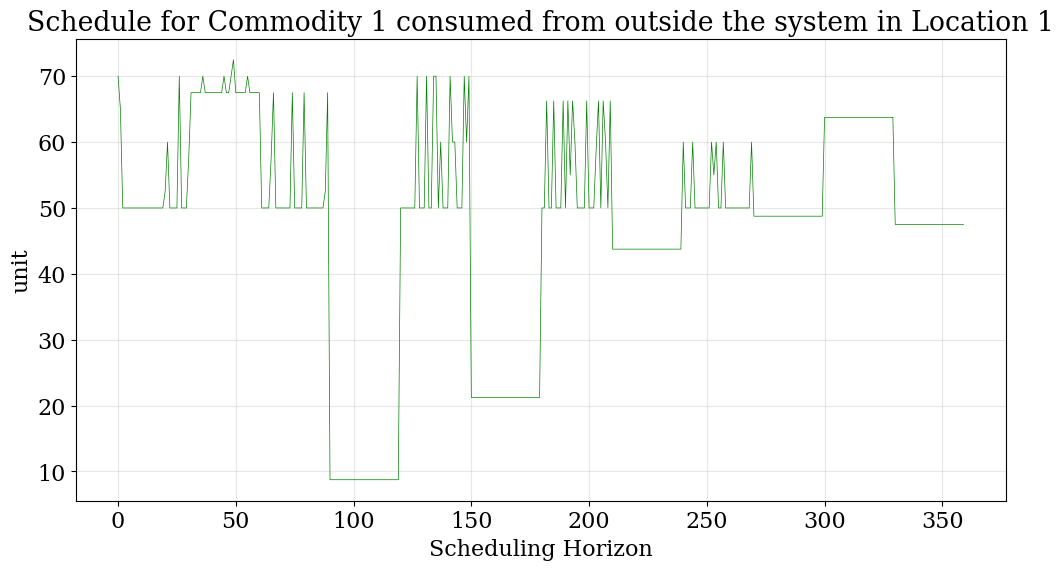

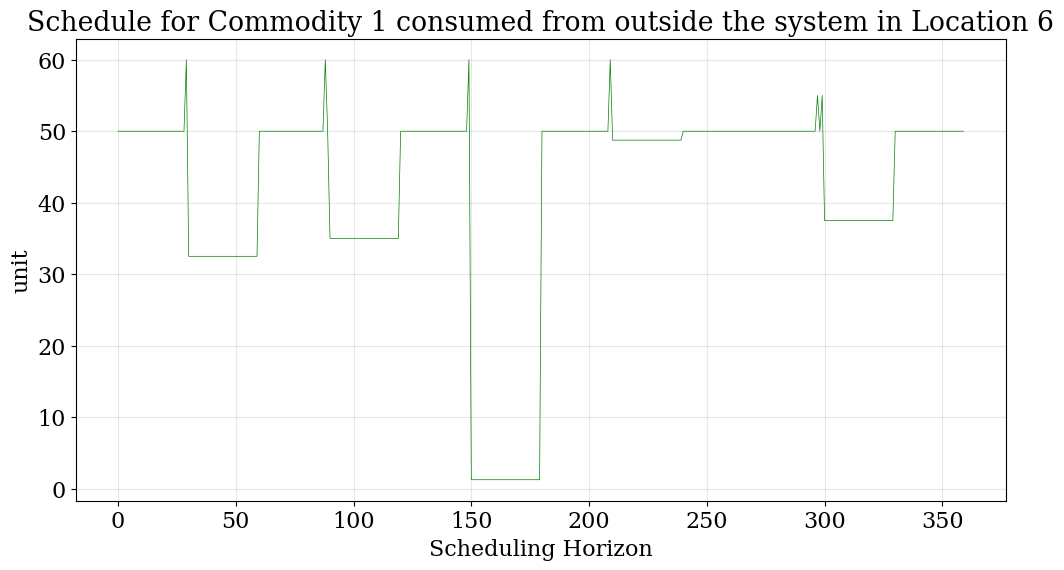

In [67]:
plot_results.schedule(results=results_mincost, y_axis='C', component='com1_pur', location='loc1', color='green')
plot_results.schedule(results=results_mincost, y_axis='C', component='com1_pur', location='loc6', color='green')

In [68]:
problem_mincost.Capex_network.pprint()
problem_mincost.Fopex_network.pprint()
problem_mincost.Vopex_network.pprint()

Capex_network : Capex at network scale
    Size=12, Index=scales_network
    Key : Lower : Value              : Upper : Fixed : Stale : Domain
      0 :     0 : 15870.416666666666 :  None : False : False : NonNegativeReals
      1 :     0 : 15870.416666666666 :  None : False : False : NonNegativeReals
      2 :     0 : 15870.416666666666 :  None : False : False : NonNegativeReals
      3 :     0 : 15870.416666666666 :  None : False : False : NonNegativeReals
      4 :     0 : 15870.416666666666 :  None : False : False : NonNegativeReals
      5 :     0 : 15870.416666666666 :  None : False : False : NonNegativeReals
      6 :     0 : 15870.416666666666 :  None : False : False : NonNegativeReals
      7 :     0 : 15870.416666666666 :  None : False : False : NonNegativeReals
      8 :     0 : 15870.416666666666 :  None : False : False : NonNegativeReals
      9 :     0 : 15870.416666666666 :  None : False : False : NonNegativeReals
     10 :     0 : 15870.416666666666 :  None : False : Fa

In [69]:
problem_mincost.Capex_transport_network.pprint()
problem_mincost.Fopex_transport_network.pprint()
problem_mincost.Vopex_transport_network.pprint()

Capex_transport_network : overall capex for transport at the network level
    Size=12, Index=scales_network
    Key : Lower : Value              : Upper : Fixed : Stale : Domain
      0 :     0 : 2037.9635833333332 :  None : False : False : NonNegativeReals
      1 :     0 : 2037.9635833333332 :  None : False : False : NonNegativeReals
      2 :     0 : 2037.9635833333332 :  None : False : False : NonNegativeReals
      3 :     0 : 2037.9635833333332 :  None : False : False : NonNegativeReals
      4 :     0 : 2037.9635833333332 :  None : False : False : NonNegativeReals
      5 :     0 : 2037.9635833333332 :  None : False : False : NonNegativeReals
      6 :     0 : 2037.9635833333332 :  None : False : False : NonNegativeReals
      7 :     0 : 2037.9635833333332 :  None : False : False : NonNegativeReals
      8 :     0 : 2037.9635833333332 :  None : False : False : NonNegativeReals
      9 :     0 : 2037.9635833333332 :  None : False : False : NonNegativeReals
     10 :     0 : 203

In [70]:
results_mincost.output[('objective')]

4329706.763

In [71]:
inventory1 = {loc1: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc1.name, com1_store20.resource_storage.name, 0, 29)]},
                  loc2: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc2.name, com1_store20.resource_storage.name, 0, 29)]},
                  loc3: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc3.name, com1_store20.resource_storage.name, 0, 29)]},
                  loc4: {(com1_store50, com1_store50.resource_storage): results_mincost.output['Inv'][(loc4.name, com1_store50.resource_storage.name, 0, 29)]},
                  loc5: {(com1_store50, com1_store50.resource_storage): results_mincost.output['Inv'][(loc5.name, com1_store50.resource_storage.name, 0, 29)]},
                  loc6: {(com1_store10, com1_store10.resource_storage): results_mincost.output['Inv'][(loc6.name, com1_store10.resource_storage.name, 0, 29)]},
                  loc7: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc7.name, com1_store20.resource_storage.name, 0, 29)]}
                  }
inventory1

{loc1: {(com1_store20, com1_store20_com1_in_stored): 20.0},
 loc2: {(com1_store20, com1_store20_com1_in_stored): 2.5},
 loc3: {(com1_store20, com1_store20_com1_in_stored): 10.0},
 loc4: {(com1_store50, com1_store50_com1_in_stored): 20.0},
 loc5: {(com1_store50, com1_store50_com1_in_stored): 15.0},
 loc6: {(com1_store10, com1_store10_com1_in_stored): 10.0},
 loc7: {(com1_store20, com1_store20_com1_in_stored): 0.0}}

In [72]:
sum(value for key, value in results_mincost.output['Capex_network'].items())

190444.99999999997

In [73]:
sum(value for key, value in results_mincost.output['Capex_transport_network'].items())

24455.563000000006

In [87]:
cost1 = sum(value for key, value in results_mincost.output['Capex_network'].items() if key<=0) + \
sum(value for key, value in results_mincost.output['Capex_transport_network'].items() if key<=0) + \
sum(value for key, value in results_mincost.output['Vopex_network'].items() if key<=0) + \
sum(value for key, value in results_mincost.output['Vopex_transport_network'].items() if key<=0) + \
sum(value for key, value in results_mincost.output['Demand_penalty'].items() if key[2]<=0)*500

cost1

59789.055250000005

In [92]:
inventory2 = {loc1: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc1.name, com1_store20.resource_storage.name, 1, 29)]},
                  loc2: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc2.name, com1_store20.resource_storage.name, 1, 29)]},
                  loc3: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc3.name, com1_store20.resource_storage.name, 1, 29)]},
                  loc4: {(com1_store50, com1_store50.resource_storage): results_mincost.output['Inv'][(loc4.name, com1_store50.resource_storage.name, 1, 29)]},
                  loc5: {(com1_store50, com1_store50.resource_storage): results_mincost.output['Inv'][(loc5.name, com1_store50.resource_storage.name, 1, 29)]},
                  loc6: {(com1_store10, com1_store10.resource_storage): results_mincost.output['Inv'][(loc6.name, com1_store10.resource_storage.name, 1, 29)]},
                  loc7: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc7.name, com1_store20.resource_storage.name, 1, 29)]}
                  }
inventory2

{loc1: {(com1_store20, com1_store20_com1_in_stored): 20.0},
 loc2: {(com1_store20, com1_store20_com1_in_stored): 2.5},
 loc3: {(com1_store20, com1_store20_com1_in_stored): 12.5},
 loc4: {(com1_store50, com1_store50_com1_in_stored): 25.0},
 loc5: {(com1_store50, com1_store50_com1_in_stored): 22.5},
 loc6: {(com1_store10, com1_store10_com1_in_stored): 0.0},
 loc7: {(com1_store20, com1_store20_com1_in_stored): 0.0}}

In [94]:
cost2 = sum(value for key, value in results_mincost.output['Capex_network'].items() if key<=1) + \
sum(value for key, value in results_mincost.output['Capex_transport_network'].items() if key<=1) + \
sum(value for key, value in results_mincost.output['Vopex_network'].items() if key<=1) + \
sum(value for key, value in results_mincost.output['Vopex_transport_network'].items() if key<=1) + \
sum(value for key, value in results_mincost.output['Demand_penalty'].items() if key[2]<=1)*500

cost2

121757.3855

In [95]:
inventory3 = {loc1: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc1.name, com1_store20.resource_storage.name, 2, 29)]},
                  loc2: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc2.name, com1_store20.resource_storage.name, 2, 29)]},
                  loc3: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc3.name, com1_store20.resource_storage.name, 2, 29)]},
                  loc4: {(com1_store50, com1_store50.resource_storage): results_mincost.output['Inv'][(loc4.name, com1_store50.resource_storage.name, 2, 29)]},
                  loc5: {(com1_store50, com1_store50.resource_storage): results_mincost.output['Inv'][(loc5.name, com1_store50.resource_storage.name, 2, 29)]},
                  loc6: {(com1_store10, com1_store10.resource_storage): results_mincost.output['Inv'][(loc6.name, com1_store10.resource_storage.name, 2, 29)]},
                  loc7: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc7.name, com1_store20.resource_storage.name, 2, 29)]}
                  }
inventory3

{loc1: {(com1_store20, com1_store20_com1_in_stored): 20.0},
 loc2: {(com1_store20, com1_store20_com1_in_stored): 20.0},
 loc3: {(com1_store20, com1_store20_com1_in_stored): 20.0},
 loc4: {(com1_store50, com1_store50_com1_in_stored): 50.0},
 loc5: {(com1_store50, com1_store50_com1_in_stored): 50.0},
 loc6: {(com1_store10, com1_store10_com1_in_stored): 10.0},
 loc7: {(com1_store20, com1_store20_com1_in_stored): 20.0}}

In [96]:
cost3 = sum(value for key, value in results_mincost.output['Capex_network'].items() if key<=2) + \
sum(value for key, value in results_mincost.output['Capex_transport_network'].items() if key<=2) + \
sum(value for key, value in results_mincost.output['Vopex_network'].items() if key<=2) + \
sum(value for key, value in results_mincost.output['Vopex_transport_network'].items() if key<=2) + \
sum(value for key, value in results_mincost.output['Demand_penalty'].items() if key[2]<=2)*500

cost3

182328.79075

In [80]:
inventory4 = {loc1: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc1.name, com1_store20.resource_storage.name, 3, 29)]},
                  loc2: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc2.name, com1_store20.resource_storage.name, 3, 29)]},
                  loc3: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc3.name, com1_store20.resource_storage.name, 3, 29)]},
                  loc4: {(com1_store50, com1_store50.resource_storage): results_mincost.output['Inv'][(loc4.name, com1_store50.resource_storage.name, 3, 29)]},
                  loc5: {(com1_store50, com1_store50.resource_storage): results_mincost.output['Inv'][(loc5.name, com1_store50.resource_storage.name, 3, 29)]},
                  loc6: {(com1_store10, com1_store10.resource_storage): results_mincost.output['Inv'][(loc6.name, com1_store10.resource_storage.name, 3, 29)]},
                  loc7: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc7.name, com1_store20.resource_storage.name, 3, 29)]}
                  }
inventory4

{loc1: {(com1_store20, com1_store20_com1_in_stored): 0.0},
 loc2: {(com1_store20, com1_store20_com1_in_stored): 0.0},
 loc3: {(com1_store20, com1_store20_com1_in_stored): 0.0},
 loc4: {(com1_store50, com1_store50_com1_in_stored): 0.0},
 loc5: {(com1_store50, com1_store50_com1_in_stored): 0.0},
 loc6: {(com1_store10, com1_store10_com1_in_stored): 0.0},
 loc7: {(com1_store20, com1_store20_com1_in_stored): 0.0}}

In [81]:
cost4 = sum(value for key, value in results_mincost.output['Capex_network'].items() if key<=3) + \
sum(value for key, value in results_mincost.output['Capex_transport_network'].items() if key<=3) + \
sum(value for key, value in results_mincost.output['Vopex_network'].items() if key<=3) + \
sum(value for key, value in results_mincost.output['Vopex_transport_network'].items() if key<=3) + \
sum(value for key, value in results_mincost.output['Demand_penalty'].items() if key[2]<=3)*500

cost4

897129.975

In [82]:
inventory5 = {loc1: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc1.name, com1_store20.resource_storage.name, 4, 29)]},
                  loc2: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc2.name, com1_store20.resource_storage.name, 4, 29)]},
                  loc3: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc3.name, com1_store20.resource_storage.name, 4, 29)]},
                  loc4: {(com1_store50, com1_store50.resource_storage): results_mincost.output['Inv'][(loc4.name, com1_store50.resource_storage.name, 4, 29)]},
                  loc5: {(com1_store50, com1_store50.resource_storage): results_mincost.output['Inv'][(loc5.name, com1_store50.resource_storage.name, 4, 29)]},
                  loc6: {(com1_store10, com1_store10.resource_storage): results_mincost.output['Inv'][(loc6.name, com1_store10.resource_storage.name, 4, 29)]},
                  loc7: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc7.name, com1_store20.resource_storage.name, 4, 29)]}
                  }
inventory5

{loc1: {(com1_store20, com1_store20_com1_in_stored): 20.0},
 loc2: {(com1_store20, com1_store20_com1_in_stored): 20.0},
 loc3: {(com1_store20, com1_store20_com1_in_stored): 20.0},
 loc4: {(com1_store50, com1_store50_com1_in_stored): 50.0},
 loc5: {(com1_store50, com1_store50_com1_in_stored): 50.0},
 loc6: {(com1_store10, com1_store10_com1_in_stored): 10.0},
 loc7: {(com1_store20, com1_store20_com1_in_stored): 20.0}}

In [83]:
cost5 = sum(value for key, value in results_mincost.output['Capex_network'].items() if key<=4) + \
sum(value for key, value in results_mincost.output['Capex_transport_network'].items() if key<=4) + \
sum(value for key, value in results_mincost.output['Vopex_network'].items() if key<=4) + \
sum(value for key, value in results_mincost.output['Vopex_transport_network'].items() if key<=4) + \
sum(value for key, value in results_mincost.output['Demand_penalty'].items() if key[2]<=4)*500

cost5

940960.375

In [90]:
inventory6 = {loc1: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc1.name, com1_store20.resource_storage.name, 5, 29)]},
                  loc2: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc2.name, com1_store20.resource_storage.name, 5, 29)]},
                  loc3: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc3.name, com1_store20.resource_storage.name, 5, 29)]},
                  loc4: {(com1_store50, com1_store50.resource_storage): results_mincost.output['Inv'][(loc4.name, com1_store50.resource_storage.name, 5, 29)]},
                  loc5: {(com1_store50, com1_store50.resource_storage): results_mincost.output['Inv'][(loc5.name, com1_store50.resource_storage.name, 5, 29)]},
                  loc6: {(com1_store10, com1_store10.resource_storage): results_mincost.output['Inv'][(loc6.name, com1_store10.resource_storage.name, 5, 29)]},
                  loc7: {(com1_store20, com1_store20.resource_storage): results_mincost.output['Inv'][(loc7.name, com1_store20.resource_storage.name, 5, 29)]}
                  }
inventory6

{loc1: {(com1_store20, com1_store20_com1_in_stored): 0.0},
 loc2: {(com1_store20, com1_store20_com1_in_stored): 0.0},
 loc3: {(com1_store20, com1_store20_com1_in_stored): 0.0},
 loc4: {(com1_store50, com1_store50_com1_in_stored): 0.0},
 loc5: {(com1_store50, com1_store50_com1_in_stored): 0.0},
 loc6: {(com1_store10, com1_store10_com1_in_stored): 0.0},
 loc7: {(com1_store20, com1_store20_com1_in_stored): 0.0}}

In [91]:
cost6 = sum(value for key, value in results_mincost.output['Capex_network'].items() if key<=5) + \
sum(value for key, value in results_mincost.output['Capex_transport_network'].items() if key<=5) + \
sum(value for key, value in results_mincost.output['Vopex_network'].items() if key<=5) + \
sum(value for key, value in results_mincost.output['Vopex_transport_network'].items() if key<=5) + \
sum(value for key, value in results_mincost.output['Demand_penalty'].items() if key[2]<=5)*500

cost6

2122186.6064999998

In [86]:
cost_res = sum(value for key, value in results_mincost.output['Capex_network'].items() if key>=6) + \
sum(value for key, value in results_mincost.output['Capex_transport_network'].items() if key>=6) + \
sum(value for key, value in results_mincost.output['Vopex_network'].items() if key>=6) + \
sum(value for key, value in results_mincost.output['Vopex_transport_network'].items() if key>=6) + \
sum(value for key, value in results_mincost.output['Demand_penalty'].items() if key[2]>=6)*500

cost_res

266319.875